# ![TensorFlow](https://img.shields.io/badge/TensorFlow-%23FF6F00.svg?style=for-the-badge&logo=TensorFlow&logoColor=white) **CHAPTER 13 - LOADING AND PREPROCESSING DATA WITH TENSORFLOW**

---

## **SETUP:**

In [97]:
# %load ../initial_settings.py
"""
Initial settings for data analysis and machine learning.
Use this with: %load ../initial_settings.py
"""

import os
import sys
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf
import keras_tuner as kt
from packaging import version

# This notebook requires Python 3.7 or above and Scikit-Learn 1.0.1 or above.
assert sys.version_info >= (3, 7)
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

# And TensorFlow 2.8 or above.
assert version.parse(tf.__version__) >= version.parse("2.8.0")

# Graphviz source.
os.environ["PATH"] += os.pathsep + "C:/Programy/Graphviz/bin/"
# Protoc source
os.environ["PATH"] += os.pathsep + "C:/Programy/protoc-22.2-win64/bin"

# Default settings for matplotlib.
DARK_BLUE = "#03002e"
LIGHT_GRAY = "#8f8f99"

plt.rc("font", size=14)
plt.rc("legend", fontsize=14)
plt.rc("text", color=DARK_BLUE)

plt.rc("axes", labelsize=14)
plt.rc("axes", titlesize=14)
plt.rc("axes", labelpad=10)
plt.rc("axes", labelcolor=DARK_BLUE)
plt.rc("axes", grid=True)

plt.rc("xtick", labelsize=12, color=DARK_BLUE)
plt.rc("ytick", labelsize=12, color=DARK_BLUE)
plt.rc("xtick.major", pad=10)
plt.rc("ytick.major", pad=10)

plt.rc("grid", color=LIGHT_GRAY)
plt.rc("grid", linestyle="dashed")
plt.rc("grid", linewidth=0.5)
plt.rc("grid", alpha=0.5)

# Create a directory for matplotlib images.
IMAGES_PATH = Path("images")
IMAGES_PATH.mkdir(parents=True, exist_ok=True)


def save_fig(
    fig_id, tight_layout=True, fig_extension="png", resolution=300, facecolor="w"
):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution, facecolor=facecolor)


---

## **THE TF.DATA API:**

In [98]:
X = tf.range(10)  # any data tensor
dataset = tf.data.Dataset.from_tensor_slices(X)
dataset

<TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.int32, name=None)>

In [99]:
for item in dataset:
    print(item)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)


In [100]:
X_nested = {"a": ([1, 2, 3], [4, 5, 6]), "b": [7, 8, 9]}
dataset = tf.data.Dataset.from_tensor_slices(X_nested)
for item in dataset:
    print(item)


{'a': (<tf.Tensor: shape=(), dtype=int32, numpy=1>, <tf.Tensor: shape=(), dtype=int32, numpy=4>), 'b': <tf.Tensor: shape=(), dtype=int32, numpy=7>}
{'a': (<tf.Tensor: shape=(), dtype=int32, numpy=2>, <tf.Tensor: shape=(), dtype=int32, numpy=5>), 'b': <tf.Tensor: shape=(), dtype=int32, numpy=8>}
{'a': (<tf.Tensor: shape=(), dtype=int32, numpy=3>, <tf.Tensor: shape=(), dtype=int32, numpy=6>), 'b': <tf.Tensor: shape=(), dtype=int32, numpy=9>}


### **CHAINING TRANSFORMATIONS:**

In [101]:
dataset = tf.data.Dataset.from_tensor_slices(tf.range(10))
dataset = dataset.repeat(3).batch(7)
for item in dataset:
    print(item)


tf.Tensor([0 1 2 3 4 5 6], shape=(7,), dtype=int32)
tf.Tensor([7 8 9 0 1 2 3], shape=(7,), dtype=int32)
tf.Tensor([4 5 6 7 8 9 0], shape=(7,), dtype=int32)
tf.Tensor([1 2 3 4 5 6 7], shape=(7,), dtype=int32)
tf.Tensor([8 9], shape=(2,), dtype=int32)


In [102]:
dataset = dataset.map(lambda x: x * 2)  # x is a batch
for item in dataset:
    print(item)

tf.Tensor([ 0  2  4  6  8 10 12], shape=(7,), dtype=int32)
tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int32)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int32)
tf.Tensor([ 2  4  6  8 10 12 14], shape=(7,), dtype=int32)
tf.Tensor([16 18], shape=(2,), dtype=int32)


In [103]:
dataset = dataset.filter(lambda x: tf.reduce_sum(x) > 50)
for item in dataset:
    print(item)


tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int32)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int32)
tf.Tensor([ 2  4  6  8 10 12 14], shape=(7,), dtype=int32)


In [104]:
for item in dataset.take(2):
    print(item)


tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int32)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int32)


### **SHUFFLING THE DATA:**

In [105]:
dataset = tf.data.Dataset.range(10).repeat(2)
dataset = dataset.shuffle(buffer_size=4, seed=42).batch(7)
for item in dataset:
    print(item)


tf.Tensor([3 0 1 6 2 5 7], shape=(7,), dtype=int64)
tf.Tensor([8 4 1 9 4 2 3], shape=(7,), dtype=int64)
tf.Tensor([7 5 0 8 9 6], shape=(6,), dtype=int64)


### **INTERLEAVING LINES FROM MULTIPLE FILES:**

Let's start by loading and preparing the California housing dataset. We first load it, then split it into a training set, a validation set and a test set:

In [106]:
# extra code – fetches, splits and normalizes the California housing dataset

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42
)


For a very large dataset that does not fit in memory, you will typically want to split it into many files first, then have TensorFlow read these files in parallel. To demonstrate this, let's start by splitting the housing dataset and saving it to 20 CSV files:

In [107]:
# extra code – split the dataset into 20 parts and save it to CSV files


def save_to_csv_files(data, name_prefix, header=None, n_parts=10):
    housing_dir = Path() / "data" / "housing"
    housing_dir.mkdir(parents=True, exist_ok=True)
    filename_format = "my_{}_{:02d}.csv"

    filepaths = []
    m = len(data)
    chunks = np.array_split(np.arange(m), n_parts)
    for file_idx, row_indices in enumerate(chunks):
        part_csv = housing_dir / filename_format.format(name_prefix, file_idx)
        filepaths.append(str(part_csv))
        with open(part_csv, "w") as f:
            if header is not None:
                f.write(header)
                f.write("\n")
            for row_idx in row_indices:
                f.write(",".join([repr(col) for col in data[row_idx]]))
                f.write("\n")
    return filepaths


train_data = np.c_[X_train, y_train]
valid_data = np.c_[X_valid, y_valid]
test_data = np.c_[X_test, y_test]
header_cols = housing.feature_names + ["MedianHouseValue"]
header = ",".join(header_cols)

train_filepaths = save_to_csv_files(train_data, "train", header, n_parts=20)
valid_filepaths = save_to_csv_files(valid_data, "valid", header, n_parts=10)
test_filepaths = save_to_csv_files(test_data, "test", header, n_parts=10)


Okay, now let's take a peek at the first few lines of one of these CSV files:

In [108]:
print("".join(open(train_filepaths[0]).readlines()[:4]))

MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
3.5214,15.0,3.0499445061043287,1.106548279689234,1447.0,1.6059933407325193,37.63,-122.43,1.442
5.3275,5.0,6.490059642147117,0.9910536779324056,3464.0,3.4433399602385686,33.69,-117.39,1.687
3.1,29.0,7.5423728813559325,1.5915254237288134,1328.0,2.2508474576271187,38.44,-122.98,1.621



In [109]:
train_filepaths

['data\\housing\\my_train_00.csv',
 'data\\housing\\my_train_01.csv',
 'data\\housing\\my_train_02.csv',
 'data\\housing\\my_train_03.csv',
 'data\\housing\\my_train_04.csv',
 'data\\housing\\my_train_05.csv',
 'data\\housing\\my_train_06.csv',
 'data\\housing\\my_train_07.csv',
 'data\\housing\\my_train_08.csv',
 'data\\housing\\my_train_09.csv',
 'data\\housing\\my_train_10.csv',
 'data\\housing\\my_train_11.csv',
 'data\\housing\\my_train_12.csv',
 'data\\housing\\my_train_13.csv',
 'data\\housing\\my_train_14.csv',
 'data\\housing\\my_train_15.csv',
 'data\\housing\\my_train_16.csv',
 'data\\housing\\my_train_17.csv',
 'data\\housing\\my_train_18.csv',
 'data\\housing\\my_train_19.csv']

In [110]:
filepath_dataset = tf.data.Dataset.list_files(train_filepaths, seed=42)
# extra code – shows that the file paths are shuffled
for filepath in filepath_dataset:
    print(filepath)


tf.Tensor(b'data\\housing\\my_train_15.csv', shape=(), dtype=string)
tf.Tensor(b'data\\housing\\my_train_08.csv', shape=(), dtype=string)
tf.Tensor(b'data\\housing\\my_train_03.csv', shape=(), dtype=string)
tf.Tensor(b'data\\housing\\my_train_01.csv', shape=(), dtype=string)
tf.Tensor(b'data\\housing\\my_train_10.csv', shape=(), dtype=string)
tf.Tensor(b'data\\housing\\my_train_05.csv', shape=(), dtype=string)
tf.Tensor(b'data\\housing\\my_train_19.csv', shape=(), dtype=string)
tf.Tensor(b'data\\housing\\my_train_16.csv', shape=(), dtype=string)
tf.Tensor(b'data\\housing\\my_train_02.csv', shape=(), dtype=string)
tf.Tensor(b'data\\housing\\my_train_09.csv', shape=(), dtype=string)
tf.Tensor(b'data\\housing\\my_train_00.csv', shape=(), dtype=string)
tf.Tensor(b'data\\housing\\my_train_07.csv', shape=(), dtype=string)
tf.Tensor(b'data\\housing\\my_train_12.csv', shape=(), dtype=string)
tf.Tensor(b'data\\housing\\my_train_04.csv', shape=(), dtype=string)
tf.Tensor(b'data\\housing\\my_trai

In [111]:
n_readers = 5
dataset = filepath_dataset.interleave(
    lambda filepath: tf.data.TextLineDataset(filepath).skip(1), cycle_length=n_readers
)

for line in dataset.take(5):
    print(line)


tf.Tensor(b'4.6477,38.0,5.03728813559322,0.911864406779661,745.0,2.5254237288135593,32.64,-117.07,1.504', shape=(), dtype=string)
tf.Tensor(b'8.72,44.0,6.163179916317992,1.0460251046025104,668.0,2.794979079497908,34.2,-118.18,4.159', shape=(), dtype=string)
tf.Tensor(b'3.8456,35.0,5.461346633416459,0.9576059850374065,1154.0,2.8778054862842892,37.96,-122.05,1.598', shape=(), dtype=string)
tf.Tensor(b'3.3456,37.0,4.514084507042254,0.9084507042253521,458.0,3.2253521126760565,36.67,-121.7,2.526', shape=(), dtype=string)
tf.Tensor(b'3.6875,44.0,4.524475524475524,0.993006993006993,457.0,3.195804195804196,34.04,-118.15,1.625', shape=(), dtype=string)


### **PREPROCESSING THE DATA:**

In [112]:
# extra code – compute the mean and standard deviation of each feature

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)


StandardScaler()

In [113]:
X_mean, X_std = scaler.mean_, scaler.scale_  # extra code
n_inputs = 8


def parse_csv_line(line):
    defs = [0.0] * n_inputs + [tf.constant([], dtype=tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults=defs)
    return tf.stack(fields[:-1]), tf.stack(fields[-1:])


def preprocess(line):
    X, y = parse_csv_line(line)
    return (X - X_mean) / X_std, y


In [114]:
preprocess(b"4.2083,44.0,5.3232,0.9171,846.0,2.3370,37.47,-122.2,2.782")


(<tf.Tensor: shape=(8,), dtype=float32, numpy=
 array([ 0.16579159,  1.216324  , -0.05204564, -0.39215982, -0.5277444 ,
        -0.2633488 ,  0.8543046 , -1.3072058 ], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.782], dtype=float32)>)

### **PUTTING EVERYTHING TOGETHER + PREFETCHING:**

In [115]:
def csv_reader_dataset(
    filepaths,
    n_readers=5,
    n_read_threads=None,
    n_parse_threads=5,
    shuffle_buffer_size=10_000,
    seed=42,
    batch_size=32,
):
    dataset = tf.data.Dataset.list_files(filepaths, seed=seed)
    dataset = dataset.interleave(
        lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
        cycle_length=n_readers,
        num_parallel_calls=n_read_threads,
    )  # type: ignore
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.shuffle(shuffle_buffer_size, seed=seed)
    return dataset.batch(batch_size).prefetch(1)


In [116]:
# extra code – show the first couple of batches produced by the dataset

example_set = csv_reader_dataset(train_filepaths, batch_size=5)
for X_batch, y_batch in example_set.take(2):
    print("X = ", X_batch)
    print("y = ", y_batch)
    print()


X =  tf.Tensor(
[[-1.2345318   0.1879177  -0.18384208  0.19340092 -0.4273575   0.49201018
   1.0838584  -1.3871703 ]
 [-1.3836461  -0.7613805  -0.3076956  -0.07978077 -0.05045014  0.32237166
   0.50294524 -0.1027696 ]
 [-0.41767654 -0.91959685 -0.5876468  -0.01253252  2.441884   -0.30059808
  -0.68699217  0.521939  ]
 [-0.58831733  0.02970133 -0.70486885  0.16348003  0.8174406  -0.29916376
  -0.70573175  0.6568782 ]
 [-1.3526396  -1.868895   -0.84703934 -0.0277291   0.58563805 -0.10333684
  -1.3756571   1.2116159 ]], shape=(5, 8), dtype=float32)
y =  tf.Tensor(
[[0.804]
 [0.53 ]
 [1.745]
 [2.045]
 [3.25 ]], shape=(5, 1), dtype=float32)

X =  tf.Tensor(
[[-0.16590534  1.8491895  -0.24013318 -0.0694841  -0.141711   -0.41202638
   0.994848   -1.4321475 ]
 [ 1.07839    -1.3942459   0.28620654 -0.16576889  6.659048    0.0645566
  -0.5698724   0.6068984 ]
 [-1.1326606   0.1879177  -0.06163051 -0.01793594 -0.75224614 -0.19871424
   2.7235353  -1.6570449 ]
 [ 1.3308945  -0.36583957  0.3440259 

Here is a short description of each method in the `Dataset` class:

In [117]:
# extra code – list all methods of the tf.data.Dataset class
for m in dir(tf.data.Dataset):
    if not (m.startswith("_") or m.endswith("_")):
        func = getattr(tf.data.Dataset, m)
        if hasattr(func, "__doc__"):
            print("● {:30s}{}".format(m + "()", func.__doc__.split("\n")[0]))


● apply()                       Applies a transformation function to this dataset.
● as_numpy_iterator()           Returns an iterator which converts all elements of the dataset to numpy.
● batch()                       Combines consecutive elements of this dataset into batches.
● bucket_by_sequence_length()   A transformation that buckets elements in a `Dataset` by length.
● cache()                       Caches the elements in this dataset.
● cardinality()                 Returns the cardinality of the dataset, if known.
● choose_from_datasets()        Creates a dataset that deterministically chooses elements from `datasets`.
● concatenate()                 Creates a `Dataset` by concatenating the given dataset with this dataset.
● element_spec()                The type specification of an element of this dataset.
● enumerate()                   Enumerates the elements of this dataset.
● filter()                      Filters this dataset according to `predicate`.
● flat_map()         

### **USING THE DATASET WITH KERAS:**

In [118]:
train_set = csv_reader_dataset(train_filepaths)
valid_set = csv_reader_dataset(valid_filepaths)
test_set = csv_reader_dataset(test_filepaths)

In [119]:
# extra code – for reproducibility
tf.keras.backend.clear_session()
tf.random.set_seed(42)

model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(
            30,
            activation="relu",
            kernel_initializer="he_normal",
            input_shape=X_train.shape[1:],
        ),
        tf.keras.layers.Dense(1),
    ]
)
model.compile(loss="mse", optimizer="sgd")
model.fit(train_set, validation_data=valid_set, epochs=5)


Epoch 1/5
363/363 [==============================] - 2s 4ms/step - loss: 0.9832 - val_loss: 8.4881
Epoch 2/5
363/363 [==============================] - 1s 3ms/step - loss: 0.4573 - val_loss: 7.4752
Epoch 3/5
363/363 [==============================] - 1s 3ms/step - loss: 0.6943 - val_loss: 3.1595
Epoch 4/5
363/363 [==============================] - 1s 3ms/step - loss: 0.5793 - val_loss: 13.1842
Epoch 5/5
363/363 [==============================] - 1s 3ms/step - loss: 0.4867 - val_loss: 39.0868


In [120]:
test_mse = model.evaluate(test_set)
new_set = test_set.take(3)  # pretend we have 3 new samples
y_pred = model.predict(new_set)  # or you could just pass a NumPy array


3/3 [==============================] - 0s 13ms/step


In [121]:
# extra code – defines the optimizer and loss function for training
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
loss_fn = tf.keras.losses.mean_squared_error

n_epochs = 5
for epoch in range(n_epochs):
    for X_batch, y_batch in train_set:
        # extra code – perform one Gradient Descent step
        #              as explained in Chapter 12
        print("\rEpoch {}/{}".format(epoch + 1, n_epochs), end="")
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))


Epoch 5/5

In [122]:
@tf.function
def train_one_epoch(model, optimizer, loss_fn, train_set):
    for X_batch, y_batch in train_set:
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))


optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
loss_fn = tf.keras.losses.mean_squared_error
n_epochs = 5

for epoch in range(n_epochs):
    print("\rEpoch {}/{}".format(epoch + 1, n_epochs), end="")
    train_one_epoch(model, optimizer, loss_fn, train_set)


Epoch 5/5

---

## **THE TFRECORD FORMAT:**

A TFRecord file is just a list of binary records. You can create one using a `tf.io.TFRecordWriter`:

In [123]:
with tf.io.TFRecordWriter("data/my_data.tfrecord") as f:
    f.write(b"This is the first record")
    f.write(b"And this is the second record")


And you can read it using a `tf.data.TFRecordDataset`:

In [124]:
filepaths = ["data/my_data.tfrecord"]
dataset = tf.data.TFRecordDataset(filepaths)
for item in dataset:
    print(item)


tf.Tensor(b'This is the first record', shape=(), dtype=string)
tf.Tensor(b'And this is the second record', shape=(), dtype=string)


You can read multiple TFRecord files with just one `TFRecordDataset`. By default it will read them one at a time, but if you set `num_parallel_reads=3`, it will read 3 at a time in parallel and interleave their records:

In [125]:
# extra code – shows how to read multiple files in parallel and interleave them

filepaths = ["data/my_test_{}.tfrecord".format(i) for i in range(5)]
for i, filepath in enumerate(filepaths):
    with tf.io.TFRecordWriter(filepath) as f:
        for j in range(3):
            f.write("File {} rercord {}".format(i, j).encode("utf-8"))

dataset = tf.data.TFRecordDataset(filepaths, num_parallel_reads=3)
for item in dataset:
    print(item)


tf.Tensor(b'File 0 rercord 0', shape=(), dtype=string)
tf.Tensor(b'File 1 rercord 0', shape=(), dtype=string)
tf.Tensor(b'File 2 rercord 0', shape=(), dtype=string)
tf.Tensor(b'File 0 rercord 1', shape=(), dtype=string)
tf.Tensor(b'File 1 rercord 1', shape=(), dtype=string)
tf.Tensor(b'File 2 rercord 1', shape=(), dtype=string)
tf.Tensor(b'File 0 rercord 2', shape=(), dtype=string)
tf.Tensor(b'File 1 rercord 2', shape=(), dtype=string)
tf.Tensor(b'File 2 rercord 2', shape=(), dtype=string)
tf.Tensor(b'File 3 rercord 0', shape=(), dtype=string)
tf.Tensor(b'File 4 rercord 0', shape=(), dtype=string)
tf.Tensor(b'File 3 rercord 1', shape=(), dtype=string)
tf.Tensor(b'File 4 rercord 1', shape=(), dtype=string)
tf.Tensor(b'File 3 rercord 2', shape=(), dtype=string)
tf.Tensor(b'File 4 rercord 2', shape=(), dtype=string)


### **COMPRESSED TFRECORD FILES:**

In [126]:
options = tf.io.TFRecordOptions(compression_type="GZIP")
with tf.io.TFRecordWriter("data/my_compressed.tfrecord", options) as f:
    f.write(b"Compress, compress, compress!")

In [127]:
dataset = tf.data.TFRecordDataset(
    ["data/my_compressed.tfrecord"], compression_type="GZIP"
)
for item in dataset:
    print(item)

tf.Tensor(b'Compress, compress, compress!', shape=(), dtype=string)


### **A BRIEF INTRODUCTION TO PROTOCOL BUFFERS:**

For this section you need to [install protobuf](https://developers.google.com/protocol-buffers/docs/downloads). In general you will not have to do so when using TensorFlow, as it comes with functions to create and parse protocol buffers of type `tf.train.Example`, which are generally sufficient. However, in this section we will learn about protocol buffers by creating our own simple protobuf definition, so we need the protobuf compiler (`protoc`): we will use it to compile the protobuf definition to a Python module that we can then use in our code.

First let's write a simple protobuf definition:

In [128]:
%%writefile proto/person.proto
syntax = "proto3";
message Person {
    string name = 1;
    int32 id = 2;
    repeated string email = 3;
}

Overwriting proto/person.proto


And let's compile it (the `--descriptor_set_out` and `--include_imports` options are only required for the `tf.io.decode_proto()` example below):

In [129]:
!protoc proto/person.proto --python_out=. --descriptor_set_out=data/person.desc --include_imports

In [130]:
sys.path.append("proto/")

from person_pb2 import Person  # import the generated access class

person = Person(name="Al", id=123, email=["a@b.com"])  # create a Person
print(person)  # display the Person


name: "Al"
id: 123
email: "a@b.com"



In [131]:
person.name  # read a field

'Al'

In [132]:
person.name = "Alice"  # modify a field

In [133]:
person.email[0]  # repeated fields can be accessed like arrays

'a@b.com'

In [134]:
person.email.append("c@d.com")  # add an email address

In [135]:
serialized = person.SerializeToString()  # serialize person to a byte string
serialized

b'\n\x05Alice\x10{\x1a\x07a@b.com\x1a\x07c@d.com'

In [136]:
person2 = Person()  # create a new Person
person2.ParseFromString(serialized)  # parse the byte string (27 bytes long)

27

In [137]:
person == person2  # now they are equal

True

### **CUSTOM PROTOBUF:**

In rare cases, you may want to parse a custom protobuf (like the one we just created) in TensorFlow. For this you can use the `tf.io.decode_proto()` function:

In [138]:
# extra code – shows how to use the tf.io.decode_proto() function

person_tf = tf.io.decode_proto(
    bytes=serialized,
    message_type="Person",
    field_names=["name", "id", "email"],
    output_types=[tf.string, tf.int32, tf.string],
    descriptor_source="proto/person.desc",
)

person_tf.values

[<tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Alice'], dtype=object)>,
 <tf.Tensor: shape=(1,), dtype=int32, numpy=array([123])>,
 <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d.com'], dtype=object)>]

For more details, see the [`tf.io.decode_proto()`](https://www.tensorflow.org/api_docs/python/tf/io/decode_proto) documentation.

### **TENSORFLOW PROTOBUFS:**

Here is the definition of the tf.train.Example protobuf:

```proto
syntax = "proto3";

message BytesList { repeated bytes value = 1; }
message FloatList { repeated float value = 1 [packed = true]; }
message Int64List { repeated int64 value = 1 [packed = true]; }
message Feature {
    oneof kind {
        BytesList bytes_list = 1;
        FloatList float_list = 2;
        Int64List int64_list = 3;
    }
};
message Features { map<string, Feature> feature = 1; };
message Example { Features features = 1; };
```

In [139]:
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Feature, Features, Example

person_example = Example(
    features=Features(
        feature={
            "name": Feature(bytes_list=BytesList(value=[b"Alice"])),
            "id": Feature(int64_list=Int64List(value=[123])),
            "emails": Feature(bytes_list=BytesList(value=[b"a@b.cm", b"c@d.com"])),
        }
    )
)


In [140]:
with tf.io.TFRecordWriter("data/my_contacts.tfrecord") as f:
    for _ in range(5):
        f.write(person_example.SerializeToString())


### **LOADING AND PARSING EXAMPLES:**

In [141]:
feature_description = {
    "name": tf.io.FixedLenFeature([], tf.string, default_value=""),
    "id": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "emails": tf.io.VarLenFeature(tf.string),
}


def parse(serialized_example):
    return tf.io.parse_single_example(serialized_example, feature_description)


dataset = tf.data.TFRecordDataset(["data/my_contacts.tfrecord"]).map(parse)
for parsed_example in dataset:
    print(parsed_example)


{'emails': <tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x00000175A2AD3790>, 'id': <tf.Tensor: shape=(), dtype=int64, numpy=123>, 'name': <tf.Tensor: shape=(), dtype=string, numpy=b'Alice'>}
{'emails': <tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x0000017716647760>, 'id': <tf.Tensor: shape=(), dtype=int64, numpy=123>, 'name': <tf.Tensor: shape=(), dtype=string, numpy=b'Alice'>}
{'emails': <tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x00000175A2AD1810>, 'id': <tf.Tensor: shape=(), dtype=int64, numpy=123>, 'name': <tf.Tensor: shape=(), dtype=string, numpy=b'Alice'>}
{'emails': <tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x00000177166466E0>, 'id': <tf.Tensor: shape=(), dtype=int64, numpy=123>, 'name': <tf.Tensor: shape=(), dtype=string, numpy=b'Alice'>}
{'emails': <tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x00000175A2AD32E0>, 'id': <tf.Tensor: shape=(), dtype=int64, numpy=123>, '

In [142]:
tf.sparse.to_dense(parsed_example["emails"], default_value=b"")


<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'a@b.cm', b'c@d.com'], dtype=object)>

In [143]:
parsed_example["emails"].values

<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'a@b.cm', b'c@d.com'], dtype=object)>

In [144]:
def parse(serialized_examples):
    return tf.io.parse_example(serialized_examples, feature_description)


dataset = tf.data.TFRecordDataset(["data/my_contacts.tfrecord"]).batch(2).map(parse)
for parsed_examples in dataset:
    print(parsed_examples)  # two elements at a time


{'emails': <tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x00000177166B21D0>, 'id': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([123, 123], dtype=int64)>, 'name': <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'Alice', b'Alice'], dtype=object)>}
{'emails': <tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x00000177166B1F00>, 'id': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([123, 123], dtype=int64)>, 'name': <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'Alice', b'Alice'], dtype=object)>}
{'emails': <tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x00000177166B21D0>, 'id': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([123], dtype=int64)>, 'name': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Alice'], dtype=object)>}


In [145]:
parsed_example

{'emails': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x175a2ad32e0>,
 'id': <tf.Tensor: shape=(), dtype=int64, numpy=123>,
 'name': <tf.Tensor: shape=(), dtype=string, numpy=b'Alice'>}

### **EXTRA MATERIAL - STORING IMAGES AND TENSORS IN TFRECORDS:**

Let's load and display an example image:

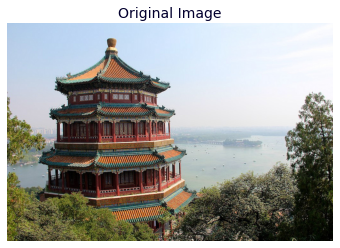

In [146]:
from sklearn.datasets import load_sample_images

img = load_sample_images()["images"][0]
plt.imshow(img)
plt.axis("off")
plt.title("Original Image")
plt.show()


Now let's create an `Example` protobuf containing the image encoded as JPEG:

In [147]:
data = tf.io.encode_jpeg(img)
example_with_image = Example(
    features=Features(
        feature={
            "image": Feature(bytes_list=BytesList(value=[data.numpy()])),
        }
    )
)
serialized_example = example_with_image.SerializeToString()
with tf.io.TFRecordWriter("data/my_image.tfrecord") as f:
    f.write(serialized_example)


Finally, let's create a tf.data pipeline that will read this TFRecord file, parse each `Example` protobuf (in this case just one), and parse and display the image that the example contains:

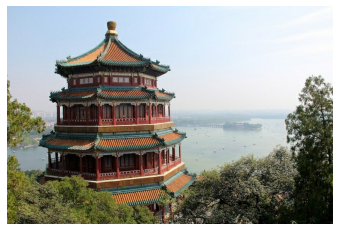

In [148]:
feature_description = {"image": tf.io.VarLenFeature(tf.string)}


def parse(serialized_example):
    example_with_image = tf.io.parse_single_example(
        serialized_example, feature_description
    )
    return tf.io.decode_jpeg(example_with_image["image"].values[0])
    # or you can use tf.io.decode_image() instead


dataset = tf.data.TFRecordDataset("data/my_image.tfrecord").map(parse)
for image in dataset:
    plt.imshow(image)
    plt.axis("off")
    plt.show()


Or use `decode_image()` which supports BMP, GIF, JPEG and PNG formats:

Tensors can be serialized and parsed easily using `tf.io.serialize_tensor()` and `tf.io.parse_tensor()`:

In [149]:
tensor = tf.constant([[0., 1.], [2., 3.], [4., 5.]])
serialized = tf.io.serialize_tensor(tensor)
serialized

<tf.Tensor: shape=(), dtype=string, numpy=b'\x08\x01\x12\x08\x12\x02\x08\x03\x12\x02\x08\x02"\x18\x00\x00\x00\x00\x00\x00\x80?\x00\x00\x00@\x00\x00@@\x00\x00\x80@\x00\x00\xa0@'>

In [150]:
tf.io.parse_tensor(serialized, out_type=tf.float32)

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[0., 1.],
       [2., 3.],
       [4., 5.]], dtype=float32)>

In [151]:
sparse_tensor = parsed_example["emails"]
serialized_sparse = tf.io.serialize_sparse(sparse_tensor)
serialized_sparse

<tf.Tensor: shape=(3,), dtype=string, numpy=
array([b'\x08\t\x12\x08\x12\x02\x08\x02\x12\x02\x08\x01"\x10\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00',
       b'\x08\x07\x12\x04\x12\x02\x08\x02"\x0f\x06\x07a@b.cmc@d.com',
       b'\x08\t\x12\x04\x12\x02\x08\x01"\x08\x02\x00\x00\x00\x00\x00\x00\x00'],
      dtype=object)>

In [152]:
BytesList(value=serialized_sparse.numpy())

value: "\010\t\022\010\022\002\010\002\022\002\010\001\"\020\000\000\000\000\000\000\000\000\001\000\000\000\000\000\000\000"
value: "\010\007\022\004\022\002\010\002\"\017\006\007a@b.cmc@d.com"
value: "\010\t\022\004\022\002\010\001\"\010\002\000\000\000\000\000\000\000"

### **HANDLING LISTS OF LISTS USING THE `SequenceExample` PROTOBUF:**

```proto
syntax = "proto3";

message FeatureList { repeated Feature feature = 1; };
message FeatureLists { map<string, FeatureList> feature_list = 1; };
message SequenceExample {
    Features context = 1;
    FeatureLists feature_lists = 2;
};
```

In [153]:
from tensorflow.train import FeatureList, FeatureLists, SequenceExample

context = Features(
    feature={
        "author_id": Feature(int64_list=Int64List(value=[123])),
        "title": Feature(bytes_list=BytesList(value=[b"A", b"desert", b"place", b"."])),
        "pub_date": Feature(int64_list=Int64List(value=[1623, 12, 15])),
    }
)
content = [
    ["When", "shall", "we", "three", "meet", "again", "?"],
    ["In", "thunder", ",", "lightning", ",", "or", "in", "rain", "?"],
]
comments = [
    ["When", "the", "hurlyburly", "'s", "done", "."],
    ["When", "the", "battle", "'s", "lost", "and", "won", "."],
]


def words_to_feature(words):
    return Feature(bytes_list=BytesList(value=[word.encode("utf-8") for word in words]))


content_features = [words_to_feature(sentence) for sentence in content]
comments_features = [words_to_feature(comment) for comment in comments]

sequence_example = SequenceExample(
    context=context,
    feature_lists=FeatureLists(
        feature_list={
            "content": FeatureList(feature=content_features),
            "comments": FeatureList(feature=comments_features),
        }
    ),
)


In [154]:
sequence_example

context {
  feature {
    key: "author_id"
    value {
      int64_list {
        value: 123
      }
    }
  }
  feature {
    key: "pub_date"
    value {
      int64_list {
        value: 1623
        value: 12
        value: 15
      }
    }
  }
  feature {
    key: "title"
    value {
      bytes_list {
        value: "A"
        value: "desert"
        value: "place"
        value: "."
      }
    }
  }
}
feature_lists {
  feature_list {
    key: "comments"
    value {
      feature {
        bytes_list {
          value: "When"
          value: "the"
          value: "hurlyburly"
          value: "\'s"
          value: "done"
          value: "."
        }
      }
      feature {
        bytes_list {
          value: "When"
          value: "the"
          value: "battle"
          value: "\'s"
          value: "lost"
          value: "and"
          value: "won"
          value: "."
        }
      }
    }
  }
  feature_list {
    key: "content"
    value {
      feature {
      

In [155]:
serialized_sequence_example = sequence_example.SerializeToString()

In [156]:
context_feature_descriptions = {
    "author_id": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "title": tf.io.VarLenFeature(tf.string),
    "pub_date": tf.io.FixedLenFeature([3], tf.int64, default_value=[0, 0, 0]),
}
sequence_feature_descriptions = {
    "content": tf.io.VarLenFeature(tf.string),
    "comments": tf.io.VarLenFeature(tf.string),
}

parsed_context, parsed_feature_lists = tf.io.parse_single_sequence_example(
    serialized_sequence_example,
    context_feature_descriptions,
    sequence_feature_descriptions,
)
parsed_content = tf.RaggedTensor.from_sparse(parsed_feature_lists["content"])



In [157]:
parsed_context

{'title': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x177164f7790>,
 'author_id': <tf.Tensor: shape=(), dtype=int64, numpy=123>,
 'pub_date': <tf.Tensor: shape=(3,), dtype=int64, numpy=array([1623,   12,   15], dtype=int64)>}

In [158]:
parsed_context["title"].values

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'A', b'desert', b'place', b'.'], dtype=object)>

In [159]:
parsed_feature_lists

{'comments': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x17719a90100>,
 'content': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x1759dbdffa0>}

In [160]:
print(tf.RaggedTensor.from_sparse(parsed_feature_lists["content"]))

<tf.RaggedTensor [[b'When', b'shall', b'we', b'three', b'meet', b'again', b'?'],
 [b'In', b'thunder', b',', b'lightning', b',', b'or', b'in', b'rain', b'?']]>


---

## **KERAS PREPROCESSING LAYERS:**

### **THE `Normalization` LAYER:**

In [161]:
tf.random.set_seed(42)

norm_layer = tf.keras.layers.Normalization()
model = tf.keras.models.Sequential(
    [
        norm_layer,
        tf.keras.layers.Dense(1),
    ]
)
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=2e-3))
norm_layer.adapt(X_train)  # computes the mean and variance of every feature
model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=5)


Epoch 1/5
363/363 [==============================] - 1s 3ms/step - loss: 3.7100 - val_loss: 2.0058
Epoch 2/5
363/363 [==============================] - 1s 2ms/step - loss: 0.8005 - val_loss: 1.4589
Epoch 3/5
363/363 [==============================] - 1s 3ms/step - loss: 0.6565 - val_loss: 1.2249
Epoch 4/5
363/363 [==============================] - 1s 3ms/step - loss: 0.6274 - val_loss: 0.8389
Epoch 5/5
363/363 [==============================] - 1s 3ms/step - loss: 0.6091 - val_loss: 0.5809


In [162]:
norm_layer = tf.keras.layers.Normalization()
norm_layer.adapt(X_train)
X_train_scaled = norm_layer(X_train)
X_valid_scaled = norm_layer(X_valid)


In [163]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
model = tf.keras.models.Sequential([tf.keras.layers.Dense(1)])
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=2e-3))
model.fit(X_train_scaled, y_train, epochs=5, validation_data=(X_valid_scaled, y_valid))


Epoch 1/5
363/363 [==============================] - 1s 3ms/step - loss: 3.0469 - val_loss: 1.4385
Epoch 2/5
363/363 [==============================] - 1s 3ms/step - loss: 0.7311 - val_loss: 1.2322
Epoch 3/5
363/363 [==============================] - 1s 2ms/step - loss: 0.6072 - val_loss: 1.0468
Epoch 4/5
363/363 [==============================] - 1s 3ms/step - loss: 0.5869 - val_loss: 0.7636
Epoch 5/5
363/363 [==============================] - 1s 3ms/step - loss: 0.5784 - val_loss: 0.5497


In [164]:
final_model = tf.keras.Sequential([norm_layer, model])
X_new = X_test[:3]  # pretend we have a few new instances (unscaled)
y_pred = final_model(X_new)  # preprocesses the data and makes predictions
y_pred

<tf.Tensor: shape=(3, 1), dtype=float32, numpy=
array([[0.91678894],
       [1.6411088 ],
       [2.6353095 ]], dtype=float32)>

In [165]:
# extra code – creates a dataset to demo applying the norm_layer using map()
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(5)
dataset = dataset.map(lambda X, y: (norm_layer(X), y))
list(dataset.take(1))  # extra code – shows the first batch


[(<tf.Tensor: shape=(5, 8), dtype=float32, numpy=
  array([[-0.19397885, -1.0778134 , -0.94338703,  0.0148516 ,  0.02073434,
          -0.5729169 ,  0.9292594 , -1.4221286 ],
         [ 0.7519829 , -1.8688954 ,  0.40547714, -0.23327833,  1.8614666 ,
           0.20516504, -0.9165495 ,  1.0966994 ],
         [-0.4146911 ,  0.02970134,  0.8180874 ,  1.056782  , -0.08786613,
          -0.29983333,  1.3087264 , -1.697002  ],
         [ 1.7188953 , -1.315138  ,  0.3266428 , -0.21955259, -0.337921  ,
          -0.11146676, -0.9821363 ,  0.94177276],
         [-0.962072  , -1.2360299 , -0.05625897, -0.03124549,  1.709061  ,
          -0.3025704 , -0.80411375,  1.326592  ]], dtype=float32)>,
  <tf.Tensor: shape=(5, 1), dtype=float64, numpy=
  array([[1.442],
         [1.687],
         [1.621],
         [2.621],
         [0.956]])>)]

In [166]:
class MyNormalization(tf.keras.layers.Layer):
    def adapt(self, X):
        self.mean_ = np.mean(X, axis=0, keepdims=True)
        self.std_ = np.std(X, axis=0, keepdims=True)

    def call(self, inputs):
        eps = tf.keras.backend.epsilon()  # a small smoothing term
        return (inputs - self.mean_) / (self.std_ + eps)


In [167]:
my_norm_layer = MyNormalization()
my_norm_layer.adapt(X_train)
X_train_scaled = my_norm_layer(X_train)
X_train_scaled


<tf.Tensor: shape=(11610, 8), dtype=float32, numpy=
array([[-0.19397888, -1.0778131 , -0.9433854 , ..., -0.5729162 ,
         0.9292612 , -1.4221537 ],
       [ 0.75198305, -1.868895  ,  0.40547806, ...,  0.20516534,
        -0.9165477 ,  1.0966716 ],
       [-0.41469115,  0.02970133,  0.8180882 , ..., -0.29983276,
         1.3087282 , -1.697027  ],
       ...,
       [-1.2233232 ,  0.5043504 , -0.51600325, ...,  0.13449073,
        -0.7197856 ,  1.1466475 ],
       [-0.9355699 ,  1.8491895 , -0.10878453, ..., -0.01354496,
         0.5216831 , -0.10276958],
       [ 0.89585984,  0.1879177 ,  0.2994754 , ..., -0.17823425,
         1.1213375 , -1.3072057 ]], dtype=float32)>

### **THE `Discretization` LAYER:**

In [168]:
age = tf.constant([[10.0], [93.0], [57.0], [18.0], [37.0], [5.0]])
discretize_layer = tf.keras.layers.Discretization(bin_boundaries=[18.0, 50.0])
age_categories = discretize_layer(age)
age_categories


<tf.Tensor: shape=(6, 1), dtype=int64, numpy=
array([[0],
       [2],
       [2],
       [1],
       [1],
       [0]], dtype=int64)>

In [169]:
discretize_layer = tf.keras.layers.Discretization(num_bins=3)
discretize_layer.adapt(age)
age_categories = discretize_layer(age)
age_categories


<tf.Tensor: shape=(6, 1), dtype=int64, numpy=
array([[1],
       [2],
       [2],
       [1],
       [2],
       [0]], dtype=int64)>

### **THE `CategoryEncoding` LAYER:**

In [170]:
onehot_layer = tf.keras.layers.CategoryEncoding(num_tokens=3)
onehot_layer(age_categories)

<tf.Tensor: shape=(6, 3), dtype=float32, numpy=
array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)>

In [171]:
two_age_categories = np.array([[1, 0], [2, 2], [2, 0]])
onehot_layer(two_age_categories)


<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[1., 1., 0.],
       [0., 0., 1.],
       [1., 0., 1.]], dtype=float32)>

In [172]:
onehot_layer = tf.keras.layers.CategoryEncoding(num_tokens=3, output_mode="count")
onehot_layer(two_age_categories)

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[1., 1., 0.],
       [0., 0., 2.],
       [1., 0., 1.]], dtype=float32)>

In [173]:
onehot_layer = tf.keras.layers.CategoryEncoding(num_tokens=3 + 3)
onehot_layer(two_age_categories + [0, 3])  # adds 3 to the second feature


<tf.Tensor: shape=(3, 6), dtype=float32, numpy=
array([[0., 1., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 1.],
       [0., 0., 1., 1., 0., 0.]], dtype=float32)>

In [174]:
tf.one_hot(two_age_categories, depth=3)

<tf.Tensor: shape=(3, 2, 3), dtype=float32, numpy=
array([[[0., 1., 0.],
        [1., 0., 0.]],

       [[0., 0., 1.],
        [0., 0., 1.]],

       [[0., 0., 1.],
        [1., 0., 0.]]], dtype=float32)>

In [175]:
# extra code – shows another way to one-hot encode each feature separately
onehot_layer = tf.keras.layers.CategoryEncoding(num_tokens=3, output_mode="one_hot")
tf.keras.layers.concatenate(
    [onehot_layer(cat) for cat in tf.transpose(two_age_categories)]
)


<tf.Tensor: shape=(3, 6), dtype=float32, numpy=
array([[0., 1., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 1.],
       [0., 0., 1., 1., 0., 0.]], dtype=float32)>

In [176]:
# extra code – shows another way to do this, using tf.one_hot() and Flatten
tf.keras.layers.Flatten()(tf.one_hot(two_age_categories, depth=3))

<tf.Tensor: shape=(3, 6), dtype=float32, numpy=
array([[0., 1., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 1.],
       [0., 0., 1., 1., 0., 0.]], dtype=float32)>

### **THE `StringLookup` LAYER:**

In [177]:
cities = ["Auckland", "Paris", "Paris", "San Francisco"]
str_lookup_layer = tf.keras.layers.StringLookup()
str_lookup_layer.adapt(cities)
str_lookup_layer([["Paris"], ["Auckland"], ["Auckland"], ["Montreal"]])


<tf.Tensor: shape=(4, 1), dtype=int64, numpy=
array([[1],
       [3],
       [3],
       [0]], dtype=int64)>

In [178]:
str_lookup_layer = tf.keras.layers.StringLookup(num_oov_indices=5)
str_lookup_layer.adapt(cities)
str_lookup_layer([["Paris"], ["Auckland"], ["Foo"], ["Bar"], ["Baz"]])


<tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[5],
       [7],
       [4],
       [3],
       [4]], dtype=int64)>

In [179]:
str_lookup_layer = tf.keras.layers.StringLookup(output_mode="one_hot")
str_lookup_layer.adapt(cities)
str_lookup_layer([["Paris"], ["Auckland"], ["Auckland"], ["Montreal"]])


<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.]], dtype=float32)>

In [180]:
# extra code – an example using the IntegerLookup layer
ids = [123, 456, 789]
int_lookup_layer = tf.keras.layers.IntegerLookup()
int_lookup_layer.adapt(ids)
int_lookup_layer([[123], [456], [123], [111]])

<tf.Tensor: shape=(4, 1), dtype=int64, numpy=
array([[3],
       [2],
       [3],
       [0]], dtype=int64)>

### **THE `Hashing` LAYER:**

In [181]:
hashing_layer = tf.keras.layers.Hashing(num_bins=10)
hashing_layer([["Paris"], ["Tokyo"], ["Auckland"], ["Montreal"]])


<tf.Tensor: shape=(4, 1), dtype=int64, numpy=
array([[0],
       [1],
       [9],
       [1]], dtype=int64)>

### **ENCODING CATEGORICAL FEATURES USING EMBEDDINGS:**

In [182]:
tf.random.set_seed(42)
embedding_layer = tf.keras.layers.Embedding(input_dim=5, output_dim=2)
embedding_layer(np.array([2, 4, 2]))


<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[ 0.02194278,  0.02114949],
       [ 0.01954533, -0.01665308],
       [ 0.02194278,  0.02114949]], dtype=float32)>

**Warning**: there's a bug in Keras 2.8.0 ([issue #16101](https://github.com/keras-team/keras/issues/16101)) which prevents using a `StringLookup` layer as the first layer of a `Sequential` model. Luckily, there's a simple workaround: just add an `InputLayer` as the first layer.

In [183]:
tf.random.set_seed(42)

ocean_prox = ["<1H OCEAN", "INLAND", "NEAR OCEAN", "NEAR BAY", "ISLAND"]
str_lookup_layer = tf.keras.layers.StringLookup()
str_lookup_layer.adapt(ocean_prox)

lookup_and_embed = tf.keras.Sequential(
    [
        tf.keras.layers.InputLayer(input_shape=[], dtype=tf.string),  # WORKAROUND
        str_lookup_layer,
        tf.keras.layers.Embedding(
            input_dim=str_lookup_layer.vocabulary_size(), output_dim=2
        ),
    ]
)
lookup_and_embed(np.array(["<1H OCEAN", "ISLAND", "<1H OCEAN"]))


<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[ 0.03959534,  0.005139  ],
       [-0.04569303,  0.04460174],
       [ 0.03959534,  0.005139  ]], dtype=float32)>

In [184]:
# extra code – set seeds and generates fake random data
# (feel free to load the real dataset if you prefer)
tf.random.set_seed(42)
np.random.seed(42)

X_train_num = np.random.rand(10_000, 8)
X_train_cat = np.random.choice(ocean_prox, size=10_000)
y_train = np.random.rand(10_000, 8)

X_valid_num = np.random.rand(2_000, 8)
X_valid_cat = np.random.choice(ocean_prox, size=2_000)
y_valid = np.random.rand(2_000, 1)

num_input = tf.keras.layers.Input(shape=[8], name="num")
cat_input = tf.keras.layers.Input(shape=[], dtype=tf.string, name="cat")
cat_embeddings = lookup_and_embed(cat_input)
encoded_inputs = tf.keras.layers.concatenate([num_input, cat_embeddings])
outputs = tf.keras.layers.Dense(1)(encoded_inputs)

model = tf.keras.Model(inputs=[num_input, cat_input], outputs=[outputs])
model.compile(loss="mse", optimizer="sgd")
history = model.fit(
    (X_train_num, X_train_cat),
    y_train,
    epochs=5,
    validation_data=((X_valid_num, X_valid_cat), y_valid),
)


Epoch 1/5
313/313 [==============================] - 1s 3ms/step - loss: 0.1518 - val_loss: 0.1244
Epoch 2/5
313/313 [==============================] - 1s 3ms/step - loss: 0.1106 - val_loss: 0.1008
Epoch 3/5
313/313 [==============================] - 1s 2ms/step - loss: 0.0951 - val_loss: 0.0919
Epoch 4/5
313/313 [==============================] - 1s 2ms/step - loss: 0.0890 - val_loss: 0.0882
Epoch 5/5
313/313 [==============================] - 1s 3ms/step - loss: 0.0864 - val_loss: 0.0867


In [185]:
# extra code – shows that the model can also be trained using a tf.data.Dataset
train_set = tf.data.Dataset.from_tensor_slices(
    ((X_train_num, X_train_cat), y_train)
).batch(32)
valid_set = tf.data.Dataset.from_tensor_slices(
    ((X_valid_num, X_valid_cat), y_valid)
).batch(32)

history = model.fit(train_set, epochs=5, validation_data=valid_set)


Epoch 1/5
313/313 [==============================] - 1s 4ms/step - loss: 0.0851 - val_loss: 0.0862
Epoch 2/5
313/313 [==============================] - 1s 3ms/step - loss: 0.0844 - val_loss: 0.0857
Epoch 3/5
313/313 [==============================] - 1s 3ms/step - loss: 0.0840 - val_loss: 0.0855
Epoch 4/5
313/313 [==============================] - 1s 3ms/step - loss: 0.0838 - val_loss: 0.0853
Epoch 5/5
313/313 [==============================] - 1s 3ms/step - loss: 0.0836 - val_loss: 0.0852


In [186]:
# extra code – shows that the dataset can contain dictionaries
train_set = tf.data.Dataset.from_tensor_slices(
    ({"num": X_train_num, "cat": X_train_cat}, y_train)
).batch(32)
valid_set = tf.data.Dataset.from_tensor_slices(
    ({"num": X_valid_num, "cat": X_valid_cat}, y_valid)
).batch(32)

history = model.fit(train_set, epochs=5, validation_data=valid_set)


Epoch 1/5
313/313 [==============================] - 1s 3ms/step - loss: 0.0835 - val_loss: 0.0852
Epoch 2/5
313/313 [==============================] - 1s 3ms/step - loss: 0.0834 - val_loss: 0.0851
Epoch 3/5
313/313 [==============================] - 1s 4ms/step - loss: 0.0834 - val_loss: 0.0851
Epoch 4/5
313/313 [==============================] - 1s 4ms/step - loss: 0.0833 - val_loss: 0.0851
Epoch 5/5
313/313 [==============================] - 1s 3ms/step - loss: 0.0833 - val_loss: 0.0851


### **TEXT PREPROCESSING:**

In [187]:
train_data = ["To be", "!(to be)", "That's the question", "Be, be, be."]
text_vec_layer = tf.keras.layers.TextVectorization()
text_vec_layer.adapt(train_data)
text_vec_layer(["Be good!", "Question: be or be?"])

<tf.Tensor: shape=(2, 4), dtype=int64, numpy=
array([[2, 1, 0, 0],
       [6, 2, 1, 2]], dtype=int64)>

In [188]:
text_vec_layer = tf.keras.layers.TextVectorization(ragged=True)
text_vec_layer.adapt(train_data)
text_vec_layer(["Be good!", "Question: be or be?"])

<tf.RaggedTensor [[2, 1], [6, 2, 1, 2]]>

In [189]:
text_vec_layer = tf.keras.layers.TextVectorization(output_mode="tf_idf")
text_vec_layer.adapt(train_data)
text_vec_layer(["Be good!", "Question: be or be?"])

<tf.Tensor: shape=(2, 6), dtype=float32, numpy=
array([[0.96725637, 0.6931472 , 0.        , 0.        , 0.        ,
        0.        ],
       [0.96725637, 1.3862944 , 0.        , 0.        , 0.        ,
        1.0986123 ]], dtype=float32)>

In [190]:
2 * np.log(1 + 4 / (1 + 3))

1.3862943611198906

In [191]:
1 * np.log(1 + 4 / (1 + 1))

1.0986122886681098

### **USING PRETRAINED LANGUAGE MODEL COMPONENTS:**

In [ ]:
import tensorflow_hub as hub

hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim50/2")
sentence_embeddings = hub_layer(tf.constant(["To be", "Not to be"]))
sentence_embeddings.numpy().round(2)


### **IMAGE PREPROCESSING LAYERS:**

In [196]:
from sklearn.datasets import load_sample_images

images = load_sample_images()["images"]
crop_image_layer = tf.keras.layers.CenterCrop(height=100, width=100)
cropped_images = crop_image_layer(images)

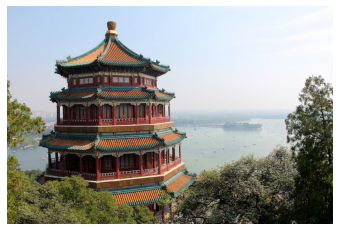

In [197]:
plt.imshow(images[0])
plt.axis("off")
plt.show()

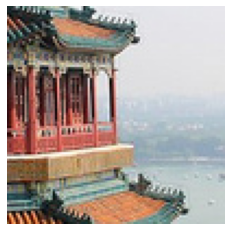

In [198]:
plt.imshow(cropped_images[0] / 255)
plt.axis("off")
plt.show()

---

# **TENSORFLOW DATASETS:**

In [199]:
import tensorflow_datasets as tfds

datasets = tfds.load(name="mnist")
mnist_train, mnist_test = datasets["train"], datasets["test"]

In [200]:
for batch in mnist_train.shuffle(10_000, seed=42).batch(32).prefetch(1):
    images = batch["image"]
    labels = batch["label"]
    # [...] do something with the images and labels

In [201]:
mnist_train = mnist_train.shuffle(10_000, seed=42).batch(32)
mnist_train = mnist_train.map(lambda items: (items["image"], items["label"]))
mnist_train = mnist_train.prefetch(1)

In [202]:
train_set, valid_set, test_set = tfds.load(
    name="mnist", split=["train[:90%]", "train[90%:]", "test"], as_supervised=True
)  # type: ignore
train_set = train_set.shuffle(10_000, seed=42).batch(32).prefetch(1)
valid_set = valid_set.batch(32).cache()
test_set = test_set.batch(32).cache()

tf.random.set_seed(42)

model = tf.keras.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(10, activation="softmax"),
    ]
)
model.compile(
    loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"]
)
history = model.fit(train_set, validation_data=valid_set, epochs=5)
test_loss, test_accuracy = model.evaluate(test_set)


Epoch 1/5
1688/1688 [==============================] - 8s 4ms/step - loss: 9.8541 - accuracy: 0.8324 - val_loss: 6.1705 - val_accuracy: 0.8785
Epoch 2/5
1688/1688 [==============================] - 7s 4ms/step - loss: 5.5755 - accuracy: 0.8799 - val_loss: 6.3001 - val_accuracy: 0.8518
Epoch 3/5
1688/1688 [==============================] - 7s 4ms/step - loss: 5.1239 - accuracy: 0.8827 - val_loss: 5.4186 - val_accuracy: 0.8847
Epoch 4/5
1688/1688 [==============================] - 7s 4ms/step - loss: 4.8443 - accuracy: 0.8859 - val_loss: 5.5059 - val_accuracy: 0.8872
Epoch 5/5
313/313 [==============================] - 1s 3ms/step - loss: 5.6545 - accuracy: 0.8735
